<a href="https://colab.research.google.com/github/saritmaitra/AL-VAR-VECM-/blob/main/AL_VAR__FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings
from pandas import DataFrame, merge, concat

  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13716 sha256=42522cc51be9c2ba76ad5c25d4b1262da48459778076a527854a760f2bf04c74
  Stored in directory: /root/.cache/pip/wheels/af/0b/39/340a7f15fc8d4ff5ab50847b28789afea04452a9d51b9721b5
Successfully built pyforest


In [2]:
from google.colab import files
uploaded = files.upload()

Saving AL_final_data.csv to AL_final_data.csv


In [3]:
df = pd.read_csv("AL_final_data.csv")
df.head()

<IPython.core.display.Javascript object>

,Unnamed: 0,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
0,0,2020-05-01 00:00:00,2877.125,1094465.0,1258140.0,1695.85,8846.125,107301000.0
1,1,2020-05-01 00:01:00,2875.375,1094215.0,1257935.0,1695.60,8841.250,107368000.0
2,2,2020-05-01 00:02:00,2874.625,1094165.0,1257765.0,1695.65,8837.750,107376500.0
3,3,2020-05-01 00:03:00,2874.125,1094115.0,1257565.0,1695.40,8836.750,107381500.0
4,4,2020-05-01 00:04:00,2875.250,1094190.0,1257535.0,1694.85,8841.125,107376500.0


In [4]:
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df.tail()

,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
29340,2020-05-29 20:56:00,3027.25,1111740.0,1235400.0,1731.50,9588.625,107675000.0
29341,2020-05-29 20:57:00,3027.25,1111750.0,1235450.0,1731.20,9588.500,107830000.0
29342,2020-05-29 20:58:00,3027.25,1111650.0,1235450.0,1731.45,9588.625,107830000.0
29343,2020-05-29 20:59:00,3027.25,1113400.0,1235450.0,1731.30,9587.375,107835000.0
29344,2020-05-29 21:00:00,3027.25,1113400.0,1237150.0,1731.35,9591.125,107835000.0


In [5]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [6]:
# spliting train/test
nobs = 120 # keeping 60 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
print(train_var.shape); print(test_var.shape);

# transfoming training data set
train_trans = train_var.diff().dropna() # differencing
print('Description of diff data:'); print(train_trans.describe());

(29225, 6)
(120, 6)
Description of diff data:
                 es        eurusd  ...            nq        usdjpy
count  29224.000000  29224.000000  ...  29224.000000  2.922400e+04
mean       0.004821      0.545613  ...      0.022841  1.618533e+01
std        1.119611    289.069688  ...      3.712902  4.800882e+04
min      -37.750000 -18615.000000  ...   -131.500000 -4.778500e+06
25%       -0.500000    -50.000000  ...     -1.500000 -5.500000e+03
50%        0.000000      0.000000  ...      0.000000  0.000000e+00
75%        0.500000     50.000000  ...      1.625000  5.500000e+03
max       26.875000  18290.000000  ...     84.750000  4.752500e+06

[8 rows x 6 columns]


In [7]:
print(train_trans.corr())

              es    eurusd    gbpusd        gc        nq    usdjpy
es      1.000000  0.057666  0.168732  0.089168  0.884779  0.047760
eurusd  0.057666  1.000000  0.151638  0.058257  0.050090 -0.024220
gbpusd  0.168732  0.151638  1.000000  0.077996  0.162460 -0.026121
gc      0.089168  0.058257  0.077996  1.000000  0.108914 -0.042493
nq      0.884779  0.050090  0.162460  0.108914  1.000000  0.043127
usdjpy  0.047760 -0.024220 -0.026121 -0.042493  0.043127  1.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

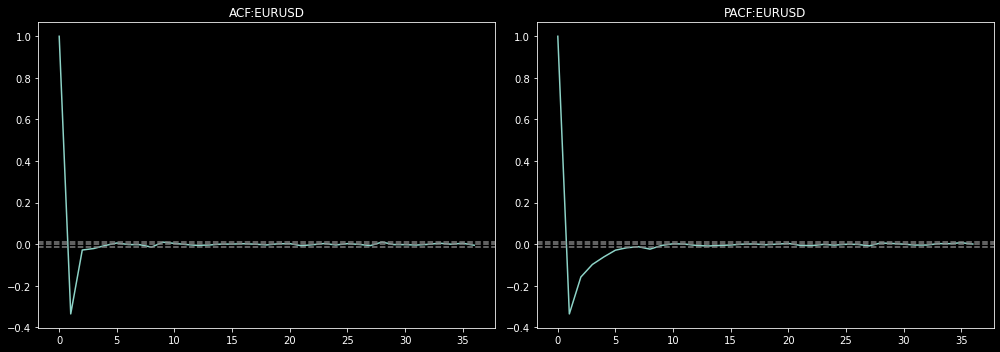

In [43]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_trans.eurusd, nlags=36, fft=False)
lag_pacf = pacf(train_trans.eurusd, method = 'ols', nlags=36) 

plt.figure(figsize=(14,5))
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.title('ACF:EURUSD')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.title('PACF:EURUSD')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

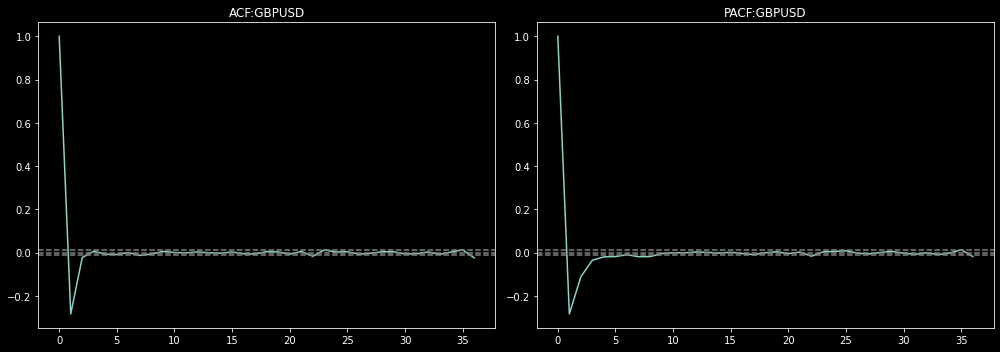

In [42]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.gbpusd, nlags=36, fft=False)
lag_pacf = pacf(train_trans.gbpusd, method = 'ols', nlags=36) 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.title('ACF:GBPUSD')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.title('PACF:GBPUSD')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

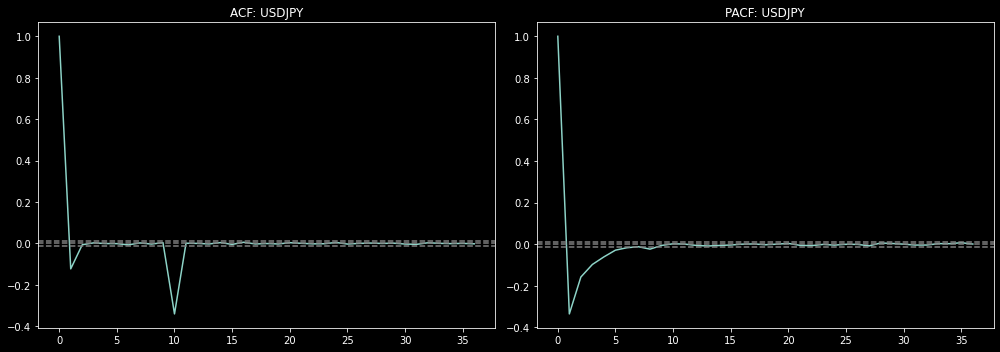

In [41]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.usdjpy, nlags=36, fft=False)
lag_pacf = pacf(train_trans.eurusd, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.title('ACF: USDJPY')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.title('PACF: USDJPY')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

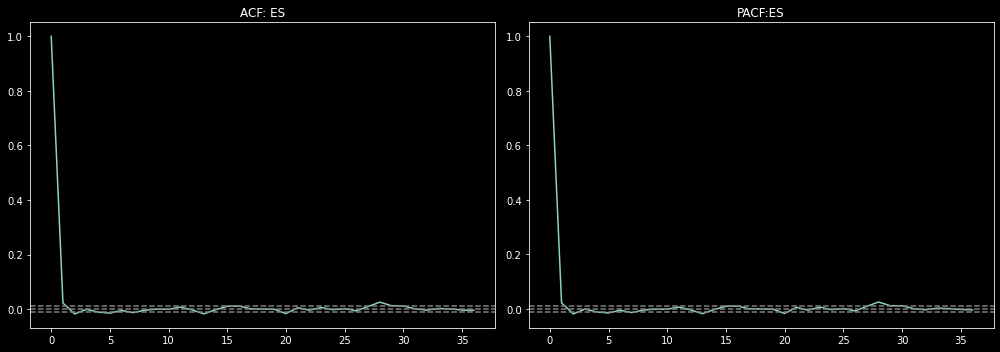

In [40]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.es, nlags=36, fft=False) 
lag_pacf = pacf(train_trans.es, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.title('ACF: ES')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.title('PACF:ES')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

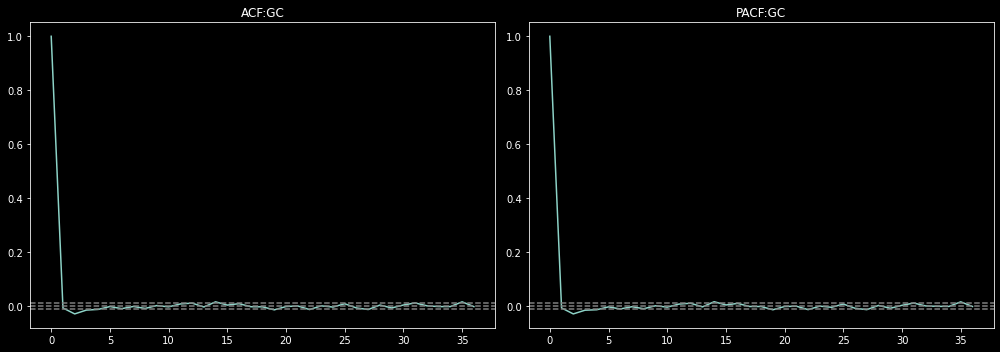

In [39]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.gc, nlags=36, fft=False) 
lag_pacf = pacf(train_trans.gc, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.title('ACF:GC')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.title('PACF:GC')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

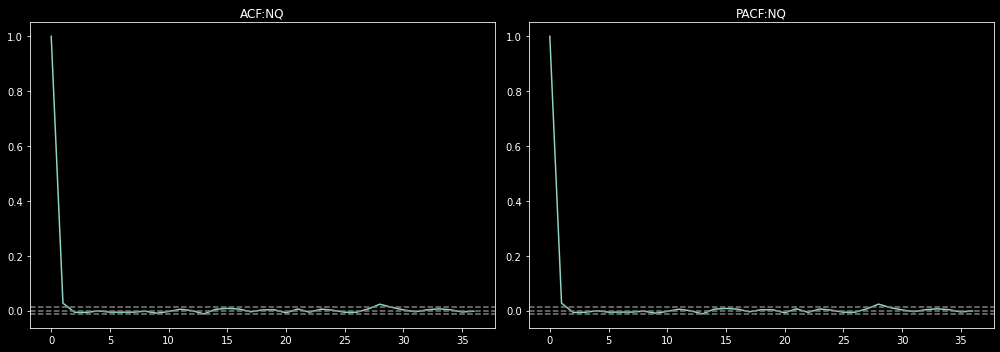

In [37]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.nq, nlags=36,fft=False) 
lag_pacf = pacf(train_trans.nq, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.title('ACF:NQ')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.title('PACF:NQ')
plt.tight_layout()

We can conclude that the time series is correlated with itself shifted by 2 minutes.


## Lag order selection

Iteratively fitting increasing orders of VAR model to identify the order that gives a model with least AIC.

In [35]:
from statsmodels.tsa.api import VAR
pd.options.display.float_format = "{:.2f}".format
model = VAR(train_trans.values)
for i in [1,2,3,4,5,6,7,8,9]:
    res = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', res.aic)
    print('BIC : ', res.bic)
    print('FPE : ', res.fpe)
    print('HQIC: ', res.hqic, '\n')

<IPython.core.display.Javascript object>

Lag Order = 1
AIC :  44.19562983789861
BIC :  44.207533950298995
FPE :  1.5628531155798278e+19
HQIC:  44.19945418768872 

Lag Order = 2
AIC :  44.13410656826821
BIC :  44.156214870782755
FPE :  1.4695993339990856e+19
HQIC:  44.141209157446625 

Lag Order = 3
AIC :  44.11592521550747
BIC :  44.1482383222285
FPE :  1.4431214623184474e+19
HQIC:  44.12630625204882 

Lag Order = 4
AIC :  44.10859715820085
BIC :  44.15111568327942
FPE :  1.4325848411965825e+19
HQIC:  44.1222568501002 

Lag Order = 5
AIC :  44.106030196989614
BIC :  44.15875475463548
FPE :  1.4289121705459634e+19
HQIC:  44.122968752262445 

Lag Order = 6
AIC :  44.104889110681995
BIC :  44.16782031516368
FPE :  1.4272825931328674e+19
HQIC:  44.12510673736424 

Lag Order = 7
AIC :  44.103883961707965
BIC :  44.1770224273527
FPE :  1.425848688865977e+19
HQIC:  44.127380867855976 

Lag Order = 8
AIC :  44.10371089313335
BIC :  44.187057234327156
FPE :  1.4256019493421416e+19
HQIC:  44.13048728682394 

Lag Order = 9
AIC :  44.104

- AIC drops to lowest at lag 8, then increases at lag 9 and then keeps increrasing. We will fo with lag 8 model.
- BIC drops to lowest at lag 3
- FPE drops to lowest at lag 8
- HQIC drops to lowest at lag 4

We shall try with lag 8 and lag3 to check which models proves better output.

In [10]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,44.45,44.45,2.017e+19,44.45
1,44.20,44.21,1.565e+19,44.20
2,44.14,44.16,1.471e+19,44.14
3,44.12,44.15,1.444e+19,44.13
4,44.11,44.15,1.434e+19,44.12
5,44.11,44.16,1.430e+19,44.12
6,44.11,44.17,1.428e+19,44.13
7,44.10,44.18,1.427e+19,44.13
8,44.10,44.19,1.426e+19,44.13
9,44.11,44.20,1.428e+19,44.14


In [31]:
### FIND BEST VAR ORDER ###
AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train_trans.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

<IPython.core.display.Javascript object>

BEST ORDER 31 BEST AIC: 43.936840832184316


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

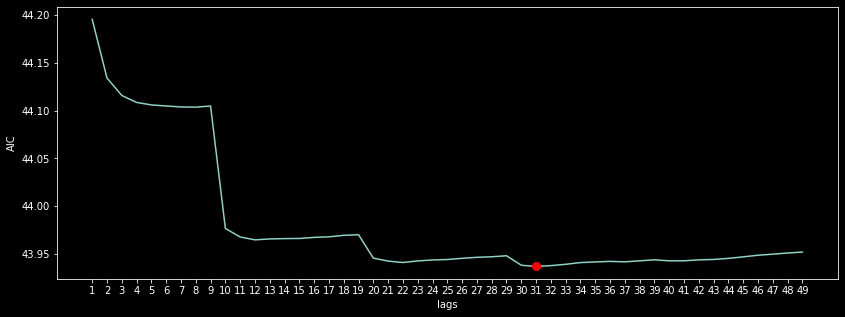

In [13]:
### PLOT AICs ### 
plt.style.use('dark_background')
plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

We have few lag values, let us try with 8 lags.

In [44]:
import statsmodels.tsa.api as smt
# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model = smt.VAR(endog = train_trans).fit(maxlags = 2)
model.summary()

<IPython.core.display.Javascript object>

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Nov, 2020
Time:                     13:04:45
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    44.1562
Nobs:                     29222.0    HQIC:                   44.1412
Log likelihood:          -893551.    FPE:                1.46960e+19
AIC:                      44.1341    Det(Omega_mle):     1.46568e+19
--------------------------------------------------------------------
Results for equation es
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.004673         0.006533            0.715           0.474
L1.es             0.010116         0.012564            0.805           0.421
L1.eurusd         0.000093         0.000025            3.767           0.000
L1

- Top of the table shows the information for the model as a whole, including values of the information criteria, 
- Further down we shows the coefficient estimates and goodness-of-fit measures for each of the equations separately. 
- Each regression equation is separated by a horizontal line.

### Durbin Watson Statistic
Checking for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic. If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series. So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.


In [45]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model.resid)

for col, val in zip(train_var.columns, out):
    print((col), ':', round(val, 2))

es : 2.0
eurusd : 2.04
gbpusd : 2.01
gc : 2.0
nq : 2.0
usdjpy : 2.0


This is to determine the existence of multi-colinearity where variables are highly correlated. The statistic is a values between 0-4 and value 2 is idea, which means there is ni auto-correlation among the variables in the model.

The serial correlation looks alright. Let’s proceed with the forecast.

In [46]:
print('GBPUSD-> EURUSD')
ca_1 = model.test_causality(causing=['gbpusd'], caused=['eurusd'], kind='wald',signif=0.05 )
print(ca_1)
print("**********************")
print('GBPUSD-> USDJPY')
ca_2 = model.test_causality(causing=['gbpusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_2)
print("**********************")
print('GBPUSD -> USDJPY, EURUSD')
ca_3 = model.test_causality(causing=['gbpusd'], caused=['usdjpy', 'eurusd'], kind='wald',signif=0.05 )
print(ca_3)
print("**********************")
print('EURUSD -> USDJPY')
ca_4 = model.test_causality(causing=['eurusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")
print('EURUSD -> GBPUSD, USDJPY')
ca_5 = model.test_causality(causing=['eurusd'], caused=['gbpusd', 'usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")

GBPUSD-> EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause eurusd: reject at 5% significance level. Test statistic: 278.360, critical value: 5.991>, p-value: 0.000>
**********************
GBPUSD-> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statistic: 4.681, critical value: 5.991>, p-value: 0.096>
**********************
GBPUSD -> USDJPY, EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause [usdjpy, eurusd]: reject at 5% significance level. Test statistic: 281.461, critical value: 9.488>, p-value: 0.000>
**********************
EURUSD -> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: eurusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statistic

## Forecasting

In [47]:
#lag_order = res.k_ar
#res.forecast(train_trans.values[-lag_order:], 30)

pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model.k_ar
print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
print(input_data)

<IPython.core.display.Javascript object>

2
[[ 1.5000e+00  1.5000e+01 -4.5000e+02 -2.0000e+00  1.0125e+01  3.0000e+03]
 [ 3.1250e+00  4.4500e+02  4.0500e+02  2.0000e-01  1.6500e+01 -3.1500e+04]]


In [68]:
fc = model.forecast(y = input_data, steps = nobs)
df_pred = DataFrame(fc, columns = train_var.columns + '_1d')
print(df_pred)

     es_1d  eurusd_1d  gbpusd_1d  gc_1d  nq_1d  usdjpy_1d
0     0.20    -148.99      28.96   0.05   0.51    3632.12
1     0.09      11.34     -22.63  -0.06   0.32     282.49
2    -0.03      21.88      -3.25  -0.00  -0.10      67.49
3     0.01     -11.86       4.68   0.00   0.03     -54.84
4     0.01       2.33      -2.31   0.00   0.04      29.08
..     ...        ...        ...    ...    ...        ...
115   0.00       0.55      -0.85   0.00   0.02      13.82
116   0.00       0.55      -0.85   0.00   0.02      13.82
117   0.00       0.55      -0.85   0.00   0.02      13.82
118   0.00       0.55      -0.85   0.00   0.02      13.82
119   0.00       0.55      -0.85   0.00   0.02      13.82

[120 rows x 6 columns]


### Inverse transformation

In [73]:
def inverse_diff(train, df_pred):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_pred.copy()
    columns = train_var.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_var[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
z = df_results.loc[:, ['es_fcast', 'eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]
print(z)

     es_fcast  eurusd_fcast  gbpusd_fcast  gc_fcast  nq_fcast  usdjpy_fcast
0     3018.20    1110261.01    1233013.96   1733.35   9514.14  107777632.12
1     3018.29    1110272.35    1232991.33   1733.29   9514.46  107777914.61
2     3018.26    1110294.23    1232988.07   1733.29   9514.36  107777982.11
3     3018.26    1110282.37    1232992.76   1733.29   9514.39  107777927.26
4     3018.27    1110284.69    1232990.44   1733.29   9514.43  107777956.34
..        ...           ...           ...       ...       ...           ...
115   3018.82    1110346.56    1232895.98   1733.44   9516.99  107779491.59
116   3018.82    1110347.11    1232895.13   1733.44   9517.02  107779505.41
117   3018.83    1110347.66    1232894.28   1733.44   9517.04  107779519.23
118   3018.83    1110348.21    1232893.43   1733.44   9517.06  107779533.05
119   3018.84    1110348.76    1232892.59   1733.44   9517.09  107779546.86

[120 rows x 6 columns]


In [83]:
z.index = test_var.index
concat = pd.concat([test_var, z], axis=1)
concat = concat[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'es','es_fcast','gc','gc_fcast','nq','nq_fcast']]
concat = concat.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
concat.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','es_fcast','gc_fcast']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,es,es_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110348.761178,1237150.000000,1232892.585422,107835000.000000,107779546.864686,3027.250000,3018.837510,1731.350000,1733.441753,9591.125000,9517.085245
2020-05-29 20:59:00,1113400.000000,1110348.210539,1235450.000000,1232893.434163,107835000.000000,107779533.045568,3027.250000,3018.832594,1731.300000,1733.440466,9587.375000,9517.062086
2020-05-29 20:58:00,1111650.000000,1110347.659901,1235450.000000,1232894.282905,107830000.000000,107779519.226451,3027.250000,3018.827677,1731.450000,1733.439179,9588.625000,9517.038926
2020-05-29 20:57:00,1111750.000000,1110347.109262,1235450.000000,1232895.131646,107830000.000000,107779505.407333,3027.250000,3018.822760,1731.200000,1733.437892,9588.500000,9517.015767
2020-05-29 20:56:00,1111740.000000,1110346.558623,1235400.000000,1232895.980388,107675000.000000,107779491.588216,3027.250000,3018.817843,1731.500000,1733.436606,9588.625000,9516.992607
2020-05-29 20:55:00,1110660.000000,1110346.007985,1234990.000000,1232896.829129,107766500.000000,107779477.769098,3027.000000,3018.812927,1731.550000,1733.435319,9587.875000,9516.969448
2020-05-29 20:54:00,1110785.000000,1110345.457346,1235090.000000,1232897.677871,107788500.000000,107779463.949980,3026.625000,3018.808010,1731.750000,1733.434032,9586.375000,9516.946288
2020-05-29 20:53:00,1110845.000000,1110344.906708,1234890.000000,1232898.526613,107784500.000000,107779450.130863,3027.000000,3018.803093,1731.750000,1733.432746,9587.875000,9516.923128
2020-05-29 20:52:00,1110745.000000,1110344.356069,1235140.000000,1232899.375354,107779000.000000,107779436.311745,3027.000000,3018.798176,1731.500000,1733.431459,9586.875000,9516.899969


In [ ]:
#def inverse_diff(actual_df, pred_df):
  #df_res = pred_df.copy()
  #columns = actual_df.columns
  #for col in columns:
    #df_res[str(col)+'_pred'] = actual_
    #df[col].iloc[-1] + df_res[str(col)].cumsum()
  #return df_res

#res = inverse_diff(df[['es','eurusd','gbpusd','gc','nq', 'usdjpy']], df_pred)
#res

## Forcast validation

In [86]:
# EURUSD forcast validation
m = concat[['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])


/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110348.761000,99.73%
2020-05-29 20:59:00,1113400.000000,1110348.211000,99.73%
2020-05-29 20:58:00,1111650.000000,1110347.660000,99.88%
2020-05-29 20:57:00,1111750.000000,1110347.109000,99.87%
2020-05-29 20:56:00,1111740.000000,1110346.559000,99.87%
2020-05-29 20:55:00,1110660.000000,1110346.008000,99.97%
2020-05-29 20:54:00,1110785.000000,1110345.457000,99.96%
2020-05-29 20:53:00,1110845.000000,1110344.907000,99.95%
2020-05-29 20:52:00,1110745.000000,1110344.356000,99.96%


## Accuracy Metrics:

In [92]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# score eur_usd
r_squared = r2_score(concat.eurusd, concat.eurusd_fcast)
mae = mean_absolute_error(concat.eurusd, concat.eurusd_fcast)
mse = mean_squared_error(concat.eurusd, concat.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((concat['eurusd'].values - concat['eurusd_fcast'].values) / concat['eurusd'].values)) * 100
msle = mean_squared_log_error(concat.eurusd, concat.eurusd_fcast)
sum = DataFrame(index = ['R-squared', 'Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [r_squared, mae, mse, rmse, mape, msle]

# score gbp_usd
r_squared = r2_score(concat.gbpusd, concat.gbpusd_fcast)
mae = mean_absolute_error(concat.gbpusd, concat.gbpusd_fcast)
mse = mean_squared_error(concat.gbpusd, concat.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((concat['gbpusd'].values - concat['gbpusd_fcast'].values) / concat['gbpusd'].values)) * 100
msle = mean_squared_log_error(concat.gbpusd, concat.gbpusd_fcast)
sum['GBPUSD'] = [r_squared, mae, mse, rmse, mape, msle]

# score usd_jpy
r_squared = r2_score(concat.usdjpy, concat.usdjpy_fcast)
mae = mean_absolute_error(concat.usdjpy, concat.usdjpy_fcast)
mse = mean_squared_error(concat.usdjpy, concat.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((concat['usdjpy'].values - concat['usdjpy_fcast'].values) / concat['usdjpy'].values)) * 100
msle = mean_squared_log_error(concat.usdjpy, concat.usdjpy_fcast)
sum['USDJPY'] = [r_squared, mae, mse, rmse, mape, msle]

# score NQ
r_squared = r2_score(concat.nq, concat.nq_fcast)
mae = mean_absolute_error(concat.nq, concat.nq_fcast)
mse = mean_squared_error(concat.nq, concat.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((concat['nq'].values - concat['nq_fcast'].values) / concat['nq'].values)) * 100
msle = mean_squared_log_error(concat.nq, concat.nq_fcast)
sum['NQ'] = [r_squared, mae, mse, rmse, mape, msle]

# score ES
r_squared = r2_score(concat.es, concat.es_fcast)
mae = mean_absolute_error(concat.es, concat.es_fcast)
mse = mean_squared_error(concat.es, concat.es_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((concat['es'].values - concat['es_fcast'].values) / concat['es'].values)) * 100
msle = mean_squared_log_error(concat.es, concat.es_fcast)
sum['ES'] = [r_squared, mae, mse, rmse, mape, msle]

# score GC
r_squared = r2_score(concat.gc, concat.gc_fcast)
mae = mean_absolute_error(concat.gc, concat.gc_fcast)
mse = mean_squared_error(concat.gc, concat.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((concat['gc'].values - concat['gc_fcast'].values) / concat['gc'].values)) * 100
msle = mean_squared_log_error(concat.gc, concat.gc_fcast)
sum['GC'] = [r_squared, mae, mse, rmse, mape, msle]
sum


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Accuracy metrics : EURUSD,GBPUSD,USDJPY,NQ,ES,GC
R-squared,-0.17,-0.70,-1.00,-1.45,-0.32,-10.56
Mean Absolute Error,583.51,1572.24,38503.25,39.07,4.83,1.22
Mean squared error,603625.34,3475801.49,2567748041.42,2271.15,31.94,1.62
Root mean squared error,776.93,1864.35,50672.95,47.66,5.65,1.27
Mean absolute % error,0.05,0.13,0.04,0.41,0.16,0.07
Mean squared log Error,0.00,0.00,0.00,0.00,0.00,0.00
